# Using the Infidelity errors (either from Calibration or a Noise Model) to Model a Circuit

Randomly adding bitflips, and adding measurement errors at the end as well (using data from `/data` and scripts from `/src`)

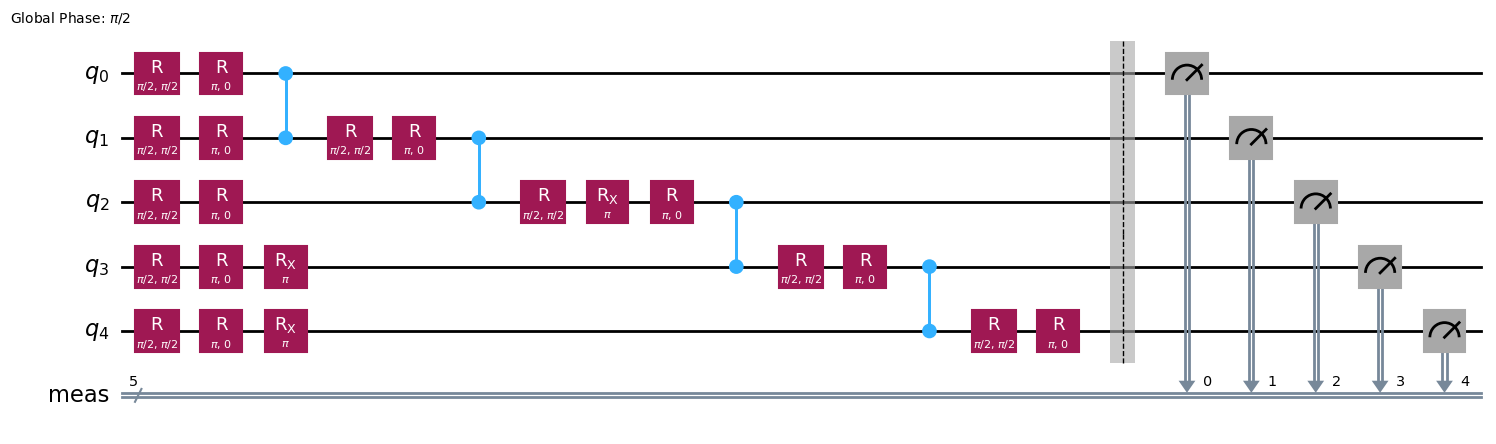

In [1]:
# Create path to src directory
# use specified path if running on e.g. a HPC system 
import sys
sys.path.insert(1, '../src')

from BitFlipper import add_BitFlips
from qiskit import QuantumCircuit, transpile

def get_test_circuit(n_qubits=5):
    qc = QuantumCircuit(n_qubits)
    
    # 1. Create Superposition on the first qubit
    # (Tests single-qubit 'r' gate noise)
    qc.h(0)
    
    # 2. Entangle neighbors linearly (Chain)
    # (Tests two-qubit 'cx' crosstalk/ZZ noise)
    for i in range(n_qubits - 1):
        qc.cx(i, i+1)
        
    # 3. Measurement (Optional, depending on if your simulator needs it)
    qc.measure_all()
    
    return qc

# Generate and print
seed = 42
qc = get_test_circuit(5)

native_gates = ['r', 'rz', 'cz'] 

# 3. Transpile
# optimization_level=3 tries hardest to reduce gate count
circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
noisy_circuit = add_BitFlips(circuit)

circuit.draw("mpl")
noisy_circuit.draw("mpl")

## Simulating a circuit applying a Hadamard to each qubit

Since we only have Gate errors, each qubit should be in a perfect 50/50 superposition of |0> and |1>

Use `measure_error = True` to see effects of Measurement Error

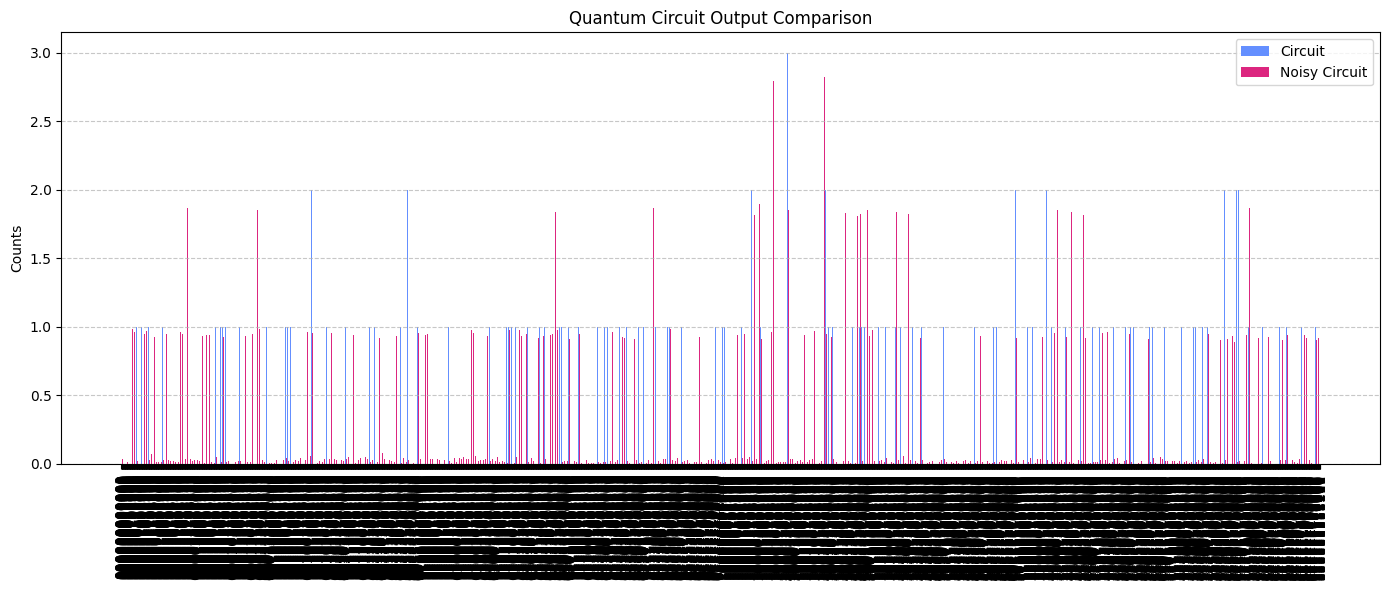


The average value of each qubit, from 0 to n-1 is: [0.49228859965509714, 0.48995594651198293, 0.48479034580214353, 0.505701599321848, 0.4949720455555729, 0.5155896432528774, 0.4975661406848638, 0.5076629696288169, 0.49629491836272366, 0.49206727476460255, 0.4927230444215824, 0.5077643314889986]


In [2]:
from Qubit_Simulator import Hadamard_Simulator

results = Hadamard_Simulator(num_qubits = 12, shots = 2**10, measure_error = True, datafile = "12-qubit-noise.csv")

print("\nThe average value of each qubit, from 0 to n-1 is: " + str(results))

## Code to Find Bitstring Counts

This logic is to be found in the `src/Qubit_Simulator.py` script

In [3]:
from qiskit import QuantumCircuit, transpile
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import numpy as np
from BitFlipper import add_BitFlips
import random
from Qubit_Simulator import pad_counts

num_qubits = 5
native_gates = ['r', 'rz', 'cz']
shots = 3
simulator = AerSimulator()
circ_seed = 312
sim_seed = 254

# Create circuit (Here 1 Hadamard each)

qc = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    qc.h(i)

qc.measure_all()

# Transpile to native gates
circuit = transpile(qc, basis_gates=native_gates, optimization_level=3)
noisy_circuit = add_BitFlips(circuit, seed = circ_seed)

# Run the circuit 
random.seed(sim_seed)
result = simulator.run(circuit, shots=shots, seed = sim_seed).result()
noisy_result = simulator.run(noisy_circuit, shots=shots, seed = sim_seed).result()

# 3. Get counts
counts = pad_counts(result.get_counts(),num_qubits)
noisy_counts = pad_counts(noisy_result.get_counts(),num_qubits)

bitstring_list = sorted(list(set(counts.keys())))
bitstring_counts = [counts.get(key, 0) for key in bitstring_list]

print(counts)
print("\n")
print("Bitstrings: " + str(bitstring_list))
print("\n")
print("Bitstring Counts: " + str(bitstring_counts))

{'00000': 0, '00001': 0, '00010': 0, '00011': 1, '00100': 0, '00101': 0, '00110': 0, '00111': 0, '01000': 0, '01001': 0, '01010': 0, '01011': 0, '01100': 0, '01101': 0, '01110': 0, '01111': 1, '10000': 0, '10001': 0, '10010': 0, '10011': 0, '10100': 0, '10101': 0, '10110': 0, '10111': 1, '11000': 0, '11001': 0, '11010': 0, '11011': 0, '11100': 0, '11101': 0, '11110': 0, '11111': 0}


Bitstrings: ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


Bitstring Counts: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
